In [1]:
using MLJ
import DataFrames
import Statistics
using PrettyPrinting
using StableRNGs


┌ Info: Precompiling StableRNGs [860ef19b-820b-49d6-a774-d7a799459cd3]
└ @ Base loading.jl:1260


In [2]:
rng = StableRNG(512)
Xraw = rand(rng, 300, 3)
y = exp.(Xraw[:,1] - Xraw[:,2] - 2Xraw[:,3] + 0.1*rand(rng, 300))
X = DataFrames.DataFrame(Xraw)

train, test = partition(eachindex(y), 0.7);

In [3]:
@load KNNRegressor
knn_model = KNNRegressor(K=10)

┌ Info: Precompiling NearestNeighbors [b8a86587-4115-5ab1-83bc-aa920d37bbce]
└ @ Base loading.jl:1260


KNNRegressor(
    K = 10,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = :uniform) @ 7…05

In [4]:
knn = machine(knn_model, X, y)

Machine{KNNRegressor} @ 5…62


In [5]:
fit!(knn, rows=train)
ŷ = predict(knn, X[test, :]) # or use rows=test
rms(ŷ, y[test])

┌ Info: Training Machine{KNNRegressor} @ 5…62.
└ @ MLJBase C:\Users\Rahul\.julia\packages\MLJBase\t7MaX\src\machines.jl:179


0.06389980172436367

<h5> or we can also use Evaluate

In [6]:
evaluate!(knn, resampling=Holdout(fraction_train=0.7, rng=StableRNG(666)),
          measure=rms) |> pprint

Evaluating over 1 folds: 100%[=========================] Time: 0:00:00


(measure = [rms],
 measurement = [0.1236738803266666],
 per_fold = [[0.1236738803266666]],
 per_observation = [missing])

<h3 > Ensemble Models

For instance, r.measurements are the measurements for all pairs of hyperparameters which you could visualise nicely:

<h4>n=20 indiactes how many models we want to  use

In [7]:
ensemble_model = EnsembleModel(atom=knn_model,n=20)

DeterministicEnsembleModel(
    atom = KNNRegressor(
            K = 10,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = :uniform),
    atomic_weights = Float64[],
    bagging_fraction = 0.8,
    rng = Random._GLOBAL_RNG(),
    n = 20,
    acceleration = ComputationalResources.CPU1{Nothing}(nothing),
    out_of_bag_measure = Any[]) @ 1…24

In [8]:
ensemble = machine(ensemble_model,X,y)

Machine{DeterministicEnsembleModel{KNNRegressor}} @ 5…89


In [13]:
# here the implicit measure is rms and measurement is mean taken over all the folds


estimates = evaluate!(ensemble,resampling=CV())

Evaluating over 6 folds: 100%[=========================] Time: 0:00:00


┌───────────┬───────────────┬─────────────────────────────────────────────────┐
│ _.measure │ _.measurement │ _.per_fold                                      │
├───────────┼───────────────┼─────────────────────────────────────────────────┤
│ rms       │ 0.0845        │ [0.0901, 0.113, 0.0733, 0.0879, 0.0644, 0.0686] │
└───────────┴───────────────┴─────────────────────────────────────────────────┘
_.per_observation = [missing]


In [14]:
estimates |> pprint

(measure = [rms],
 measurement = [0.08445867376620815],
 per_fold = [[0.09011463644115279,
              0.11278570247889533,
              0.07330169752765694,
              0.08793353021110673,
              0.06441564897609386,
              0.06858223263110173]],
 per_observation = [missing])

In [15]:
@show estimates.measurement[1]
@show mean(estimates.per_fold[1])

estimates.measurement[1] = 0.08445867376620815
mean(estimates.per_fold[1]) = 0.08285557471100123


0.08285557471100123

<h3> Systematic Tuning

Let's simultaneously tune the ensemble's bagging_fraction and the K-Nearest neighbour hyperparameter K. Since one of our models is a field of the other, we have nested hyperparameters:

In [16]:
params(ensemble_model) |> pprint

(atom = (K = 10,
         algorithm = :kdtree,
         metric = Distances.Euclidean(0.0),
         leafsize = 10,
         reorder = true,
         weights = :uniform),
 atomic_weights = [],
 bagging_fraction = 0.8,
 rng = Random._GLOBAL_RNG(),
 n = 20,
 acceleration = ComputationalResources.CPU1{Nothing}(nothing),
 out_of_bag_measure = [])

<h4>To define a tuning grid, we construct ranges for the two parameters and collate these ranges:

In [20]:
# whenever we want to do hyperparameter tuning we define these ranges to search foer best parameters 

B_range = range(ensemble_model, :bagging_fraction, lower = 0.5, upper = 1.0)
K_range = range(ensemble_model , :(atom.K) , lower = 1, upper = 20)

NumericRange(
    field = :(atom.K),
    lower = 1,
    upper = 20,
    origin = 10.5,
    unit = 9.5,
    scale = :linear) @ 4…48

In [23]:
tm = TunedModel(model = ensemble_model,tuning = Grid(resolution =10),
                 resampling=Holdout(fraction_train=0.8,rng=StableRNG(42)),
                 ranges=[B_range,K_range])
                 

┌ Info: No measure specified. Setting measure=rms. 
└ @ MLJTuning C:\Users\Rahul\.julia\packages\MLJTuning\JoSTU\src\tuned_models.jl:171


DeterministicTunedModel(
    model = DeterministicEnsembleModel(
            atom = KNNRegressor @ 7…05,
            atomic_weights = Float64[],
            bagging_fraction = 0.8,
            rng = Random._GLOBAL_RNG(),
            n = 20,
            acceleration = ComputationalResources.CPU1{Nothing}(nothing),
            out_of_bag_measure = Any[]),
    tuning = Grid(
            goal = nothing,
            resolution = 10,
            shuffle = true,
            rng = Random._GLOBAL_RNG()),
    resampling = Holdout(
            fraction_train = 0.8,
            shuffle = true,
            rng = LehmerRNG(0x00000000000000000000000000000055)),
    measure = RMS(),
    weights = nothing,
    operation = StatsBase.predict,
    range = MLJBase.NumericRange{MLJBase.Bounded,T,Symbol} where T[NumericRange @ 1…25, NumericRange @ 4…48],
    train_best = true,
    repeats = 1,
    n = nothing,
    acceleration = ComputationalResources.CPU1{Nothing}(nothing),
    acceleration_resampling = Com

In [24]:
tuned_ensemble = machine(tm, X, y)
fit!(tuned_ensemble, rows=train);

┌ Info: Training Machine{DeterministicTunedModel} @ 7…68.
└ @ MLJBase C:\Users\Rahul\.julia\packages\MLJBase\t7MaX\src\machines.jl:179
┌ Info: Attempting to evaluate 100 models.
└ @ MLJTuning C:\Users\Rahul\.julia\packages\MLJTuning\JoSTU\src\tuned_models.jl:274


In [25]:

# to see the best fitted parameters


best_ensemble = fitted_params(tuned_ensemble).best_model
@show best_ensemble.atom.K
@show best_ensemble.bagging_fraction

best_ensemble.atom.K = 3
best_ensemble.bagging_fraction = 0.5555555555555556


0.5555555555555556

In [26]:
#report gives more detailed information

r = report(tuned_ensemble)

(best_model = DeterministicEnsembleModel{KNNRegressor} @ 9…55,
 best_result = (measure = [rms],
                measurement = [0.044196638122021493],),
 best_report = (measures = Any[],
                oob_measurements = missing,),
 history = Tuple{MLJ.DeterministicEnsembleModel{KNNRegressor},NamedTuple{(:measure, :measurement),Tuple{Array{MLJBase.RMS,1},Array{Float64,1}}}}[(DeterministicEnsembleModel{KNNRegressor} @ 3…28, (measure = [rms], measurement = [0.09416850358559248])), (DeterministicEnsembleModel{KNNRegressor} @ 5…31, (measure = [rms], measurement = [0.07513533146225304])), (DeterministicEnsembleModel{KNNRegressor} @ 1…00, (measure = [rms], measurement = [0.11160258104991103])), (DeterministicEnsembleModel{KNNRegressor} @ 1…63, (measure = [rms], measurement = [0.07263665779506288])), (DeterministicEnsembleModel{KNNRegressor} @ 2…27, (measure = [rms], measurement = [0.08931296449212149])), (DeterministicEnsembleModel{KNNRegressor} @ 7…85, (measure = [rms], measurement = [0.117

<h2> For instance, r.measurements are the measurements for all pairs of hyperparameters which you could visualise nicely:

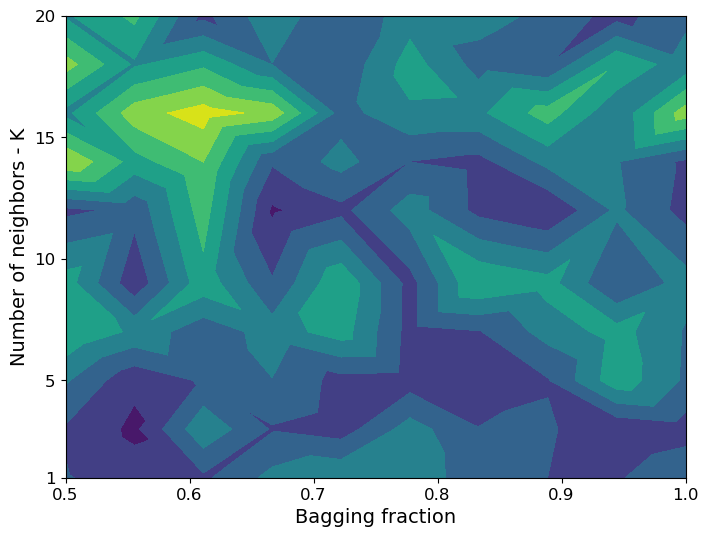

PyObject Text(29.00000000000002, 0.5, 'Number of neighbors - K')

In [27]:
using PyPlot

figure(figsize=(8,6))

res = r.plotting
vals_b = res.parameter_values[:, 1]
vals_k = res.parameter_values[:, 2]

tricontourf(vals_b, vals_k, res.measurements)
xticks(0.5:0.1:1, fontsize=12)
xlabel("Bagging fraction", fontsize=14)
yticks([1, 5, 10, 15, 20], fontsize=12)
ylabel("Number of neighbors - K", fontsize=14)

<h3> Evaluate

In [30]:
ŷ = predict(tuned_ensemble, rows=test)
rms(ŷ, y[test])

0.05323425699730739